In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import LoadDataset

In [3]:
IMG_WIDTH = 128 # Side for each transformed Image
IMG_HEIGHT = 64
IMG_DEPTH = 3 # RGB files

In [4]:
DATSET_SIZE = 100
NUM_LABELS = 3

In [5]:
data = LoadDataset.getDataSet(DATSET_SIZE, NUM_LABELS)
imgs = data[0]
labels = data[1]

[ 10.  10.   5.]


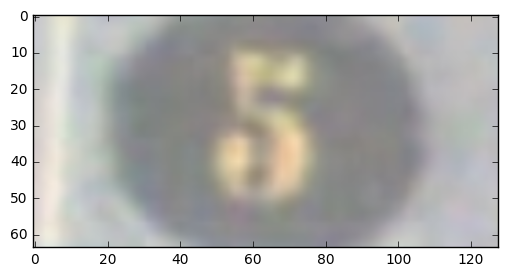

In [6]:
print (labels[9])
plt.imshow(imgs[9])

In [7]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    index_update = [int(x) for x in index_offset + labels_dense.ravel()]
    labels_one_hot.flat[index_update] = 1
    return labels_one_hot

In [8]:
# Get the dataset
X = imgs.reshape([-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH])
Y = labels

In [9]:
# Generate validation set
ratio = 0.8 # Train/Test set
randIdx = np.random.random(DATSET_SIZE) > ratio
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = [dense_to_one_hot(Y_train[:,idx], num_classes= 11) for idx in range(Y_train.shape[1])] 
Y_test = [dense_to_one_hot(Y_test[:,idx], num_classes= 11) for idx in range(Y_test.shape[1])] 
del X, Y # release some space

In [10]:
#print (np.array(Y_train).shape)

In [11]:
# Building convolutional network
network = input_data(shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)

# Training heads
allHeads = []
for idx in range(NUM_LABELS):
    fc = fully_connected(network, 128, activation='tanh')
    fc = dropout(fc, 0.8)
    softmax = fully_connected(fc, 11, activation='softmax')
    networkOut = regression(softmax, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target' + str(idx))
    allHeads.append(networkOut)

network = tflearn.merge(allHeads, mode='elemwise_sum')

In [12]:
model = tflearn.DNN(network, tensorboard_verbose=1)
feedTrainDict = {'target'+ str(i): Y_train[i] for i in range(NUM_LABELS)}
feedTestList =  [Y_test[i] for i in range(NUM_LABELS)]
model.fit({'input': X_train}, feedTrainDict, 
          validation_set= (X_test, feedTestList), n_epoch=5, snapshot_step=100, show_metric=True, run_id='convnet_mnist')

Training Step: 5  | total loss: 5.44892
| Adam_0 | epoch: 005 | loss: 0.92042 - acc: 0.6364 | val_loss: 2.04866 - val_acc: 0.6538 -- iter: 22/22
| Adam_1 | epoch: 005 | loss: 2.28418 - acc: 0.1776 | val_loss: 2.72094 - val_acc: 0.1154 -- iter: 22/22
| Adam | epoch: 005 | loss: 2.24432 - acc: 0.2008 | val_loss: 2.38889 - val_acc: 0.0641 -- iter: 22/22
Training Step: 5  | total loss: 5.44892
| Adam_0 | epoch: 005 | loss: 0.92042 - acc: 0.6364 | val_loss: 2.04866 - val_acc: 0.6538 -- iter: 22/22
| Adam_1 | epoch: 005 | loss: 2.28418 - acc: 0.1776 | val_loss: 2.72094 - val_acc: 0.1154 -- iter: 22/22
| Adam | epoch: 005 | loss: 2.24432 - acc: 0.2008 | val_loss: 2.38889 - val_acc: 0.0641 -- iter: 22/22
--
